# Fisher matrix 

Compute Fisher matrix with ARF and ADF

In [6]:
%load_ext autoreload
%autoreload 2


import numpy as np
import scipy
import os
import matplotlib.pyplot as plt
import sys
import copy
import itertools
from scipy.linalg import block_diag
import hashlib

import camb
from camb import model, initialpower
from camb.sources import GaussianSourceWindow, SplinedSourceWindow
from camb.fisher.cachers import cacher_pk, cacher_mem, cacher_dict_mem
from camb.fisher.utils import enumerate_progress, is_pos_def, cov_to_corr, set_mpl
from camb import fisher

from getdist import plots
from getdist.gaussian_mixtures import GaussianND

from os.path import join as opj

print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using CAMB 1.3.6 installed at /Users/louis/Code/CAMBfork/camb


In [2]:
from camb.fisher.cosmo import ffp10_plancklens



In [3]:
# Params to derivate 

# params_cosmo = ['As', 'ns', 'H0', 'omch2', 'ombh2']
# params_cosmo = ['logA', 'ns', 'H0', 'omch2', 'ombh2']
# params_cosmo = ['As', 'ns', 'H0', 'omch2', 'ombh2', 'mnu']
params_cosmo = ['logA', 'ns', 'cosmomc_theta', 'omch2', 'ombh2']
# params_cosmo = ['logA', 'ns', 'cosmomc_theta', 'omch2', 'ombh2', 'mnu']
# params_cosmo = ['logA', 'ns', 'H0', 'omch2', 'ombh2', 'mnu']
# params_cosmo = ['omch2', 'mnu']
# params_cosmo = ['As', 'ns', 'omch2', 'ombh2']


# fiducials = {}
# for par in params_cosmo:
#     fiducials[par] = ffp10_plancklens[par]

fiducials = ffp10_plancklens

# Select if you want to marginalise on bias parameters
marg_bias = True


In [4]:
latex = {
    'logA':r'\log(10^{10} A_\mathrm{s})',
    'As':r'A_\mathrm{s}',
    'ns': r'n_\mathrm{s}', 
    'theta_MC_100':r'100\theta_\mathrm{MC}', 
    'cosmomc_theta':r'\theta_\mathrm{MC}', 
    'ombh2':r'\Omega_\mathrm{b} h^2', 
    'omch2':r'\Omega_\mathrm{c} h^2', 
    'tau':r'\tau_\mathrm{reio}', 
    'mnu':r'\sum m_\nu', 
    'omk':r'\Omega_k', 
    'w':r'w_0',
    'wa':r'w_\mathrm{a}',
    'H0':r'H_0'
}

# Get the gaussian covariance matrix

In [5]:
# ngal_tot = 30 * 3600*(180/np.pi)**2 # 30 gal / arcmin2 
# sig_eps = 0.3
# ng_i = ngal_tot/10

In [6]:
nzbin = 20

max_dist_bin = 5
# max_dist_bin = 2*(nzbin+1)

zmin = 0.9
zmax= 1.8
sigz = 0.01

# zmean = 1
# zmin = zmean - nzbin/2*sigz
# zmax = zmean + nzbin/2*sigz


zobs = np.linspace(zmin, zmax, nzbin)
sgzar = np.ones_like(zobs)*sigz

print(zobs)

lmin = 10
lmax = 300

# bias = 1.66
# biasR=3.8

bias = 'Euclid'
bias_euclid = lambda z : 0.79 + 0.68 * z

if bias == 'Euclid':
    bg_z = bias_euclid
else:
    bg_z = lambda z : bias


if marg_bias:
    params = params_cosmo + [f'b{i:02}' for i in range(nzbin)]
    mean = [fiducials[par] for par in list(params_cosmo)] +  [bg_z(zobs[i]) for i in range(nzbin)]
    labels = [latex[par] for par in params_cosmo] + [f'b{i:02}' for i in range(nzbin)]

else:
    params = params_cosmo
    mean = [fiducials[par] for par in list(params_cosmo)]
    labels = [latex[par] for par in params_cosmo] 

    
for i in range(nzbin):
    fiducials[f'b{i:02}'] = bg_z(zobs[i])
    
npar= len(params)

[0.9        0.94736842 0.99473684 1.04210526 1.08947368 1.13684211
 1.18421053 1.23157895 1.27894737 1.32631579 1.37368421 1.42105263
 1.46842105 1.51578947 1.56315789 1.61052632 1.65789474 1.70526316
 1.75263158 1.8       ]


In [7]:
fiducials

{'label': 'ffp10_plancklens',
 'As': 2.119631e-09,
 'logA': 3.0538271099245846,
 'ns': 0.9636852,
 'cosmomc_theta': 0.010407224216796775,
 'ombh2': 0.02216571,
 'omch2': 0.1202944,
 'tau': 0.06018107,
 'mnu': 0.06,
 'omk': 0,
 'w': -1,
 'b00': 1.4020000000000001,
 'b01': 1.4342105263157896,
 'b02': 1.466421052631579,
 'b03': 1.4986315789473688,
 'b04': 1.530842105263158,
 'b05': 1.5630526315789475,
 'b06': 1.595263157894737,
 'b07': 1.6274736842105264,
 'b08': 1.6596842105263159,
 'b09': 1.6918947368421056,
 'b10': 1.7241052631578948,
 'b11': 1.7563157894736843,
 'b12': 1.7885263157894737,
 'b13': 1.8207368421052632,
 'b14': 1.852947368421053,
 'b15': 1.8851578947368424,
 'b16': 1.9173684210526318,
 'b17': 1.949578947368421,
 'b18': 1.9817894736842105,
 'b19': 2.0140000000000002}

In [8]:
def euclid_spectro_nofz(z):
    # Follow Table 3 of
    # "Euclid Collaboration et al.: Euclid preparation:
    # VII. Forecast validation for Euclid cosmological probes"
    zmin = np.array([0.9, 1.10, 1.30, 1.50])
    zmax = np.array([1.10, 1.30, 1.50, 1.80])
    zmean = (zmin + zmax)/2.
    nzmean = np.array([6.86e-4, 5.58e-4, 4.21e-4, 2.61e-4]) # h^3 Mpc^-3
    # nofz = np.interp(z, zmean, nzmean)
    # Fit a polnomial on the values to have it for all z.
    coeff = np.polyfit(zmean, nzmean, 2)
    pol = np.poly1d(coeff)
    # Cut below z=0.9 and above z=1.5
    nofz = pol(z)
#     nofz[z<0.9] = 0.
#     nofz[z>1.8] = 0.
    return nofz

In [9]:
pars = camb.CAMBparams()

if 'H0' in params_cosmo:
    pars.set_cosmology(H0=fiducials['H0'], ombh2=fiducials['ombh2'], omch2=fiducials['omch2'], mnu=fiducials['mnu'], omk=fiducials['omk'], tau=fiducials['tau'])
elif 'cosmomc_theta' in params_cosmo:
    pars.set_cosmology(cosmomc_theta=fiducials['cosmomc_theta'], ombh2=fiducials['ombh2'], omch2=fiducials['omch2'], mnu=fiducials['mnu'], omk=fiducials['omk'], tau=fiducials['tau'])

pars.InitPower.set_params(As=fiducials['As'], ns=fiducials['ns'], r=0)


results = camb.get_results(pars)

In [10]:
zs = np.arange(0.5, 2.5, 1e-4)

r = results.comoving_radial_distance(zs) 


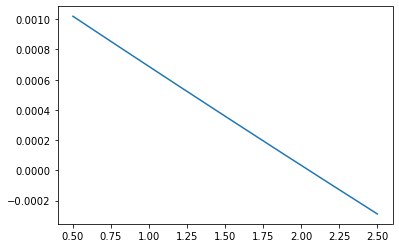

In [11]:
plt.plot(zs, euclid_spectro_nofz(zs))

1.7350040998137128e-12
2.171707007483406e-12
2.6087677370430024e-12
3.059955377373678e-12
3.538898592855521e-12
4.060100932558344e-12
4.64001086596848e-12
5.29829307288561e-12
6.059485041856874e-12
6.955304123007037e-12
8.028021531395868e-12
9.33559644243124e-12
1.0959777964482234e-11
1.3019373516339642e-11
1.569287625481514e-11
1.9258879099774337e-11
2.417228977930392e-11
3.121779371616405e-11
4.1844914203461106e-11
5.897894010627771e-11


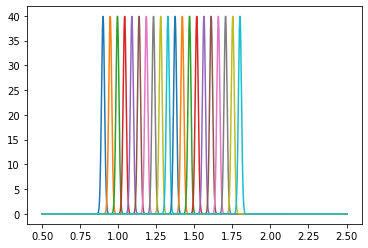

In [12]:
window = np.zeros([nzbin, len(zs)])
ngal_bin = np.zeros(nzbin)
shot_noise = {}
zbar = np.zeros(nzbin)
omega = np.zeros_like(window)

for i in range(nzbin):
    window[i] = np.exp(-(zs - zobs[i]) ** 2 / (2 * sgzar[i] ** 2)) / (np.sqrt(2 * np.pi) * sgzar[i])
    window[i] =  window[i] * euclid_spectro_nofz(zs)
    window[i] = window[i] / np.trapz(window[i], zs)
#     window[i] =  _w 
    plt.plot(zs, window[i])    
    ngal_bin[i] = np.trapz(r**2 * window[i] * euclid_spectro_nofz(zs) , r) 

    shot_noise[f'W{i+1}xW{i+1}'] = 1/ngal_bin[i]

#     shot_noise[f'W{i+1+nzbin}'] = sigz**2 / ngal_bin[i]

    zbar[i] = np.trapz(zs * window[i] * r**2 * euclid_spectro_nofz(zs), r) /ngal_bin[i]

    H_z = results.hubble_parameter(zs)

    omega[i] = window[i] * r**2 / H_z / np.trapz(window[i] * r**2 / H_z, zs)

#     shot_noise[f'W{i+1+nzbin}xW{i+1+nzbin}'] = np.trapz(omega[i]**2 * (zs-zbar[i])**2, zs) / np.trapz(window[i]**2, zs)  / ngal_bin[i]
    shot_noise[f'W{i+1+nzbin}xW{i+1+nzbin}'] = np.trapz(window[i]**2 * (zs-zbar[i])**2 * r**2, r) / np.trapz(window[i]**2 * r**2, r)  / ngal_bin[i]

#     shot_noise[f'W{i+1}xW{i+1+nzbin}'] = np.trapz(omega[i]*window[i] * (zs-zbar[i]), zs) / np.trapz(window[i]**2, zs)  / ngal_bin[i]
    shot_noise[f'W{i+1}xW{i+1+nzbin}'] = np.trapz(window[i]**2 * (zs-zbar[i]) * r**2, r) / np.trapz(window[i]**2* r**2, r)  / ngal_bin[i]
    shot_noise[f'W{i+1+nzbin}xW{i+1}'] = shot_noise[f'W{i+1}xW{i+1+nzbin}']
    
    print(shot_noise[f'W{i+1}xW{i+1+nzbin}'])

In [13]:
ngal_bin

array([19824480.30986457, 19938215.40660817, 19923209.22005406,
       19786220.99074474, 19534370.1530709 , 19174962.56503261,
       18715351.87470434, 18162830.62005604, 17524546.26176657,
       16807437.95013493, 16018190.40393508, 15163201.82024353,
       14248563.23809649, 13280047.25480042, 12263104.46720565,
       11202866.53745594, 10104155.49177734,  8971500.06778033,
        7809162.48931839,  6621185.59913435])

In [14]:
def get_source_windows(bias_bin, ibin=None):
    sources = []
    if ibin is None:
        for i in range(nzbin):
            _source = SplinedSourceWindow(z=zs, source_type='counts', W=window[i], bias_z = bias_bin[i])
            sources.append(_source)

        for i in range(nzbin):
        #     _source = SplinedSourceWindow(z=zs, source_type='arf', W=window[i], bias_z = bg_z(zobs[i]))
            _source = SplinedSourceWindow(z=zs, source_type='arf', W=window[i], bias_z = bias_bin[i])
            sources.append(_source)
#     else:
        

#     sources = [GaussianSourceWindow(redshift=zobs[i], source_type='counts', bias=bg_z(zobs[i]), sigma=sgzar[i], dlog10Ndm=0.) for i in range(nzbin)] + \
#         [GaussianSourceWindow(redshift=zobs[i], source_type='arf', bias=bg_z(zobs[i]), sigma=sgzar[i], dlog10Ndm=0.) for i in range(nzbin)]
    return sources

In [15]:
bias_bin = np.array([bg_z(zobs[i])*np.ones_like(zs) for i in range(nzbin)])

sources = get_source_windows(bias_bin)

In [16]:
tmp_dir ='./euclid'
# tmp_dir ='./euclid_test'

def get_libdir(nzbin, zmin, zmax, sigz, lmin, lmax, bias, hash_source): 
    return opj(tmp_dir, f"{fiducials['label']}", f"nzbin{nzbin}_zmin{zmin}_zmax{zmax}_sigz{sigz}_lmin{lmin}_lmax{lmax}_bias{bias}", f"SourceTerms_{hash_source}")

In [17]:
pars.SourceTerms.limber_windows = False
pars.SourceTerms.limber_phi_lmin = 100


pars.SourceTerms.counts_density = True 
pars.SourceTerms.counts_redshift = True  


pars.SourceTerms.counts_velocity = False
pars.SourceTerms.counts_lensing = False  
pars.SourceTerms.counts_radial = False  
pars.SourceTerms.counts_timedelay = False
pars.SourceTerms.counts_ISW = False
pars.SourceTerms.counts_potential = False
pars.SourceTerms.counts_evolve = False

# pars.SourceTerms.counts_velocity = True
# pars.SourceTerms.counts_lensing = True  
# pars.SourceTerms.counts_radial = True  
# pars.SourceTerms.counts_radial = True
# pars.SourceTerms.counts_timedelay = True
# pars.SourceTerms.counts_ISW = True
# pars.SourceTerms.counts_potential = True
# pars.SourceTerms.counts_evolve = True


hash_source = hashlib.sha224(pars.SourceTerms).hexdigest()
print(hash_source)

fba4e08e8e60d71128d5b07fd0ac705dca1b9e4ff0c799a0649c4e0e


In [18]:
print(pars.SourceTerms)

class: <SourceTermParams>
 limber_windows = False
 limber_phi_lmin = 100
 counts_density = True
 counts_redshift = True
 counts_lensing = False
 counts_velocity = False
 counts_radial = False
 counts_timedelay = False
 counts_ISW = False
 counts_potential = False
 counts_evolve = False
 line_phot_dipole = False
 line_phot_quadrupole = False
 line_basic = True
 line_distortions = True
 line_extra = False
 line_reionization = False
 use_21cm_mK = True
 


In [19]:
libdir = get_libdir(nzbin, zmin, zmax, sigz, lmin, lmax, bias, hash_source)

cacher = cacher_pk(libdir)
# cacher = cacher_dict_mem()
# cacher = cacher_void()

In [20]:
libdir

'./euclid/ffp10_plancklens/nzbin20_zmin0.9_zmax1.8_sigz0.01_lmin10_lmax300_biasEuclid/SourceTerms_fba4e08e8e60d71128d5b07fd0ac705dca1b9e4ff0c799a0649c4e0e'

In [21]:


fn_cls_fid = f'cls_fid'

if not cacher.is_cached(fn_cls_fid):


#     pars.set_cosmology(H0=fiducials['H0'], ombh2=fiducials['ombh2'], omch2=fiducials['omch2'], mnu=fiducials['mnu'], omk=fiducials['omk'], tau=fiducials['tau'])

#     pars.InitPower.set_params(As=fiducials['As'], ns=fiducials['ns'], r=0)


    pars.set_for_lmax(lmax, lens_potential_accuracy=1)
    #set Want_CMB to true if you also want CMB spectra or correlations
    pars.Want_CMB = False
    pars.Want_CMB_lensing = False

    #NonLinear_both or NonLinear_lens will use non-linear corrections
    pars.NonLinear = model.NonLinear_both

    pars.SourceWindows = sources

    results = camb.get_results(pars)

    cls_fid = results.get_source_cls_dict(raw_cl=True)
#     cls_fid = results.get_cmb_unlensed_scalar_array_dict(raw_cl=True)
    cacher.cache(fn_cls_fid, cls_fid)

cls_fid = cacher.load(fn_cls_fid)

In [22]:
shot_noise[f"W{i+1}xW{i+1+nzbin}"]

5.897894010627771e-11

Text(0.5, 1.0, 'ADF x ARF')

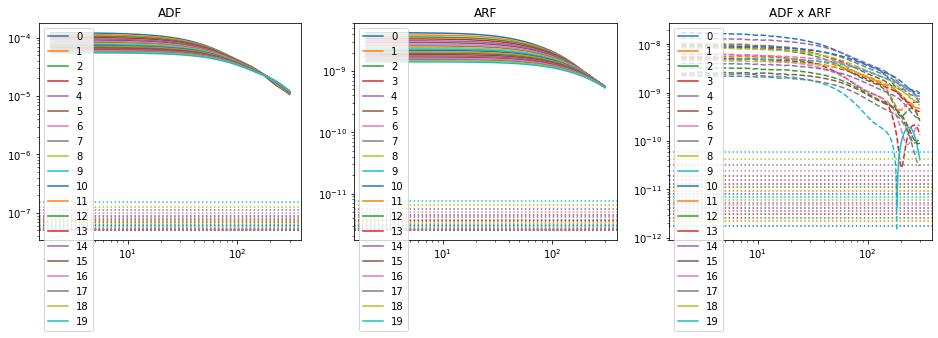

In [23]:
ls = np.arange(2, lmax)

fig, axs = plt.subplots(1, 3, figsize=(16, 4))

for i in range(nzbin):
    axs[0].loglog(ls, cls_fid[f"W{i+1}xW{i+1}"][ls], label=str(i))
    axs[0].axhline(y=shot_noise[f"W{i+1}xW{i+1}"], ls=':', c=f'C{i}')

axs[0].legend()
axs[0].set_title('ADF')

for i in range(nzbin):
    axs[1].loglog(ls, cls_fid[f"W{i+1+nzbin}xW{i+1+nzbin}"][ls], label=str(i))
    axs[1].axhline(y=shot_noise[f"W{i+1+nzbin}xW{i+1+nzbin}"], ls=':', c=f'C{i}')
axs[1].legend() 
axs[1].set_title('ARF')

for i in range(nzbin):
    is_pos = np.where(cls_fid[f"W{i+1}xW{i+1+nzbin}"][ls]>0)
    is_neg = np.where(cls_fid[f"W{i+1}xW{i+1+nzbin}"][ls]<0)
    axs[2].loglog(ls[is_pos], cls_fid[f"W{i+1}xW{i+1+nzbin}"][ls][is_pos], label=str(i), c=f'C{i}')
    axs[2].loglog(ls[is_neg], -cls_fid[f"W{i+1}xW{i+1+nzbin}"][ls][is_neg], ls='--', c=f'C{i}')
    
    axs[2].axhline(y=np.abs(shot_noise[f"W{i+1}xW{i+1+nzbin}"]), ls=':', c=f'C{i}')
    
axs[2].legend() 
axs[2].set_title('ADF x ARF')


In [24]:
# # num_cls_keys = (2*nzbin)*(2*nzbin)
# cl_keys = []
# # for j in range(2*nzbin):
# #     for i in range(2*nzbin-j):
# for i, j in itertools.combinations_with_replacement(np.arange(2*nzbin), 2):
#     cl_keys.append(f'W{i+1}xW{j+1}')

# num_cl_keys = len(cl_keys)


# cl_adf_keys = []
# for i, j in itertools.combinations_with_replacement(np.arange(nzbin), 2):
#     cl_adf_keys.append(f'W{i+1}xW{j+1}')
    
    
# cl_arf_keys = []
# for i, j in itertools.combinations_with_replacement(np.arange(nzbin), 2):
#     cl_arf_keys.append(f'W{i+1+nzbin}xW{j+1+nzbin}')

In [25]:

cl_keys = []
cl_keys_full = []

for i, j in itertools.combinations_with_replacement(np.arange(2*nzbin), 2):
    cl_keys_full.append(f'W{i+1}xW{j+1}')
    if np.abs(i-j) <= max_dist_bin:
        cl_keys.append(f'W{i+1}xW{j+1}')
    elif j>=nzbin and np.abs(i-(j-nzbin)) <= max_dist_bin:
        cl_keys.append(f'W{i+1}xW{j+1}')



num_cl_keys = len(cl_keys)


cl_adf_keys = []
for i, j in itertools.combinations_with_replacement(np.arange(nzbin), 2):
    if np.abs(i-j) <= max_dist_bin:
        cl_adf_keys.append(f'W{i+1}xW{j+1}')
    
    
cl_arf_keys = []
for i, j in itertools.combinations_with_replacement(np.arange(nzbin), 2):
    if np.abs(i-j) <= max_dist_bin:
        cl_arf_keys.append(f'W{i+1+nzbin}xW{j+1+nzbin}')
        
        
        
cl_cross_keys = []
for i in range(nzbin):
    for j in range(nzbin):
        if np.abs(i-j) <= max_dist_bin:
            cl_cross_keys.append(f'W{i+1}xW{j+1+nzbin}')

            
cl_add_keys = cl_adf_keys + cl_arf_keys

cl_keys_dict = {
    'tot':cl_keys, 
    'adf': cl_adf_keys, 
    'arf': cl_arf_keys, 
    'cross': cl_cross_keys,
    'add': cl_add_keys
}


datakeys = ['tot', 'adf', 'arf', 'cross', 'add']

In [26]:
cl_shot_noise = {}
for key in cl_keys_full:
    cl_shot_noise[key] = 0
    probeA, probeB = key.split('x')
    if probeA == probeB:
        cl_shot_noise[key] = shot_noise[key]
        
for key in cl_keys_full:
    probeA, probeB = key.split('x')
    cl_shot_noise['x'.join([probeB, probeA])] = cl_shot_noise[key]

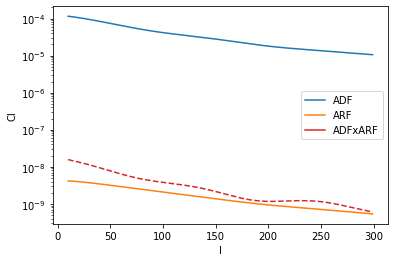

In [66]:
plt.plot(ells, cls_fid['W1xW1'][ells], label='ADF')

plt.plot(ells, cls_fid[f'W{1+nzbin}xW{1+nzbin}'][ells], label="ARF")

is_pos = np.where(cls_fid[f'W1xW{1+nzbin}'][ells]>0)
is_neg = np.where(cls_fid[f'W1xW{1+nzbin}'][ells]<0)

plt.plot(ells[is_pos], cls_fid[f'W1xW{1+nzbin}'][ells][is_pos], c='C3', label='ADFxARF')
plt.plot(ells[is_neg], -cls_fid[f'W1xW{1+nzbin}'][ells][is_neg], c='C3', ls='--')
plt.xlabel('l')
plt.ylabel('Cl')

plt.legend()
plt.yscale('log')

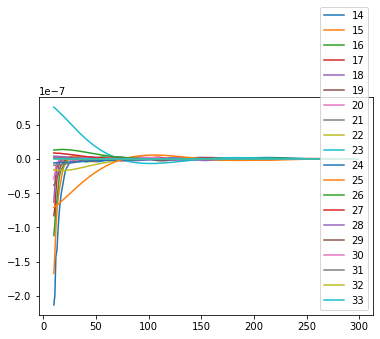

In [113]:
n = 20
for i in range(n):
    x = 4 
    u = nzbin+x+i - int(n/2)
    plt.plot(ells, cls_fid[f'W{x}xW{u}'][ells], label=f'{u}')
#     plt.semilogy(ells, np.abs(cls_fid[f'W1xW{i+1}'][ells]), label=f'{i}')
#     plt.semilogy(ells, np.abs(cls_fid[f'W1xW{nzbin}'][ells]), label=f'{i}')
    
#     plt.semilogy(ells, np.abs(cls_fid[f'W1xW{i+1+nzbin}'][ells]), ls='--', label=f'{i}')
    
plt.legend(loc=4)

In [112]:
cl_keys_dict['tot']

['W1xW1',
 'W1xW2',
 'W1xW3',
 'W1xW4',
 'W1xW5',
 'W1xW6',
 'W1xW21',
 'W1xW22',
 'W1xW23',
 'W1xW24',
 'W1xW25',
 'W1xW26',
 'W2xW2',
 'W2xW3',
 'W2xW4',
 'W2xW5',
 'W2xW6',
 'W2xW7',
 'W2xW21',
 'W2xW22',
 'W2xW23',
 'W2xW24',
 'W2xW25',
 'W2xW26',
 'W2xW27',
 'W3xW3',
 'W3xW4',
 'W3xW5',
 'W3xW6',
 'W3xW7',
 'W3xW8',
 'W3xW21',
 'W3xW22',
 'W3xW23',
 'W3xW24',
 'W3xW25',
 'W3xW26',
 'W3xW27',
 'W3xW28',
 'W4xW4',
 'W4xW5',
 'W4xW6',
 'W4xW7',
 'W4xW8',
 'W4xW9',
 'W4xW21',
 'W4xW22',
 'W4xW23',
 'W4xW24',
 'W4xW25',
 'W4xW26',
 'W4xW27',
 'W4xW28',
 'W4xW29',
 'W5xW5',
 'W5xW6',
 'W5xW7',
 'W5xW8',
 'W5xW9',
 'W5xW10',
 'W5xW21',
 'W5xW22',
 'W5xW23',
 'W5xW24',
 'W5xW25',
 'W5xW26',
 'W5xW27',
 'W5xW28',
 'W5xW29',
 'W5xW30',
 'W6xW6',
 'W6xW7',
 'W6xW8',
 'W6xW9',
 'W6xW10',
 'W6xW11',
 'W6xW21',
 'W6xW22',
 'W6xW23',
 'W6xW24',
 'W6xW25',
 'W6xW26',
 'W6xW27',
 'W6xW28',
 'W6xW29',
 'W6xW30',
 'W6xW31',
 'W7xW7',
 'W7xW8',
 'W7xW9',
 'W7xW10',
 'W7xW11',
 'W7xW12',
 'W7xW22',
 '

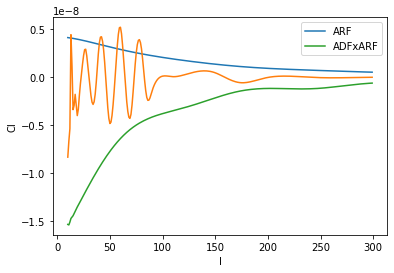

In [98]:
# plt.plot(ells, cls_fid['W1xW1'][ells], label='ADF')

plt.plot(ells, cls_fid[f'W{1+nzbin}xW{1+nzbin}'][ells], label="ARF")

# is_pos = np.where(cls_fid[f'W1xW{1+nzbin}'][ells]>0)
# is_neg = np.where(cls_fid[f'W1xW{1+nzbin}'][ells]<0)

plt.plot(ells, cls_fid[f'W1xW{-1+nzbin}'][ells], )
plt.plot(ells, cls_fid[f'W1xW{nzbin+1}'][ells],  label='ADFxARF')
# plt.plot(ells[is_neg], -cls_fid[f'W1xW{1+nzbin}'][ells][is_neg], c='C3', ls='--')
plt.xlabel('l')
plt.ylabel('Cl')

plt.legend()
# plt.yscale('log')

In [28]:
ells = np.arange(lmin, lmax)

dl_cov = np.zeros([len(ells), 2*nzbin,  2*nzbin])
for il, ell in enumerate(ells):
    for i1 in range(2*nzbin):
        for i2 in range(2*nzbin):
            dl_cov[il][i1, i2] = cls_fid[f"W{i1+1}xW{i2+1}"][ell]


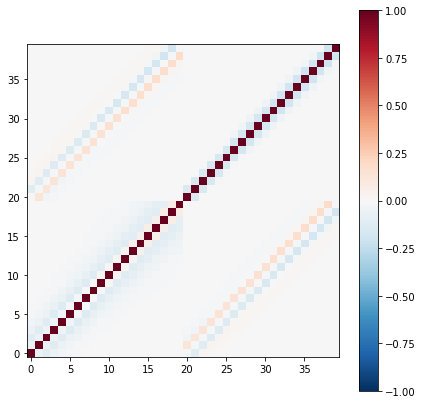

In [52]:
plt.figure(figsize=(7, 7))
plt.imshow(cov_to_corr(dl_cov[0]), cmap='RdBu_r', vmin=-1, vmax=1, origin='lower')
plt.colorbar()

plt.savefig(opj(libdir, 'figs', 'correlation_matrix.pdf'))

In [30]:
def get_cov(ells, dell, cls_fid, keys, cl_shot_noise, fsky = 0.363609919):
    cov_l = np.zeros([len(ells), len(keys), len(keys)])
    invcov_l = np.zeros([len(ells), len(keys), len(keys)])
    for il, l in enumerate_progress(ells):
#         print(l)
#         ncl = len(keys)
#         cov_l = np.zeros([ncl, ncl])

        for (idx1, key1), (idx2, key2) in itertools.combinations_with_replacement(enumerate(keys), 2):
            # print(key1, key2)
            probeA, probeB = key1.split('x')
            probeC, probeD = key2.split('x')

            cov_l[il, idx1, idx2] = 1. / (fsky * (2. * l + 1.) * dell[il]) \
                * (
                    (cls_fid['x'.join([probeA, probeC])][l] + cl_shot_noise['x'.join([probeA, probeC])]) *
                    (cls_fid['x'.join([probeB, probeD])][l] + cl_shot_noise['x'.join([probeB, probeD])]) +
                    (cls_fid['x'.join([probeA, probeD])][l] + cl_shot_noise['x'.join([probeA, probeD])]) *
                    (cls_fid['x'.join([probeB, probeC])][l] + cl_shot_noise['x'.join([probeB, probeC])])
            )

        # Get the symmetric matrix
        cov_l[il] = cov_l[il] + cov_l[il].T - np.diag(cov_l[il].diagonal())
#         cov_tot[il] = cov_l
        invcov_l[il] = np.linalg.inv(cov_l[il])
    return cov_l, invcov_l

In [31]:
ells = np.arange(lmin, lmax) 
dell = np.ones_like(ells)

In [32]:
cov = {}
invcov = {}

for p in datakeys:
    fn_cov = f'cov_{p}_maxdistbin{max_dist_bin}'
    fn_invcov = f'invcov_{p}_maxdistbin{max_dist_bin}'
    if np.any([not cacher.is_cached(fn) for fn in [fn_cov, fn_invcov]]):
        _cov, _invcov = get_cov(ells, dell, cls_fid, cl_keys_dict[p], cl_shot_noise)
        cacher.cache(fn_cov, _cov)
        cacher.cache(fn_invcov, _invcov)
    cov[p] = cacher.load(fn_cov)
    invcov[p] = cacher.load(fn_invcov)           


In [33]:
# for k, c in cov.items():
#     print(f"{k} {is_pos_def(c)} {np.max(np.linalg.cond(c))}")
    

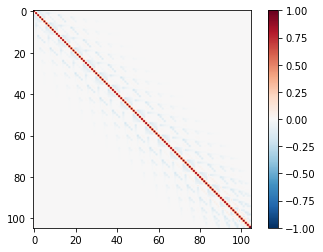

In [34]:
plt.imshow(cov_to_corr(cov['adf'][0]), cmap='RdBu_r', vmin=-1, vmax=1)
# plt.imshow(cov_to_corr(cov0[3]), cmap='RdBu', vmin=-1, vmax=1)
plt.colorbar()

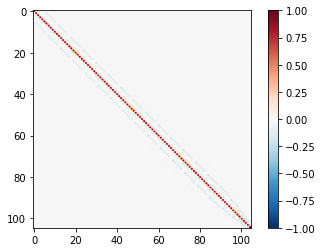

In [35]:
plt.imshow(cov_to_corr(cov['arf'][0]), cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()

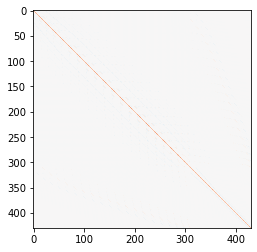

In [36]:
fig, ax = plt.subplots(1,1)

ax.imshow(cov_to_corr(cov['tot'][0]), cmap='RdBu_r', vmin=-1, vmax=1)

# ax.set_xticks(np.arange(len(cl_keys)))
# ax.set_xticklabels(cl_keys, rotation = 45)
# ax.colorbar()

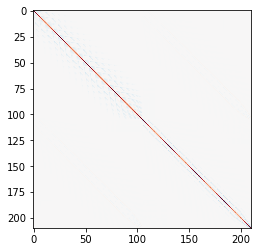

In [37]:
plt.imshow(cov_to_corr(cov['add'][0]), cmap='RdBu_r', vmin=-1, vmax=1)


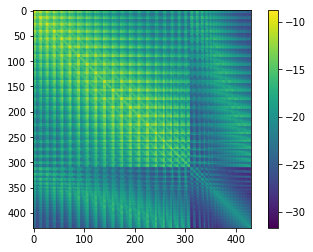

In [38]:
plt.imshow(np.log10(np.abs(cov['tot'][10])))

plt.colorbar()

In [39]:
# plt.loglog(np.diag(covmat))

In [40]:
# invcov = np.linalg.inv(covmat)

In [41]:
def get_snr(cl_keys, cls_fid, invcov_l, ells):
    snr = np.zeros(len(ells))
    cl = {}
    for il, ell in enumerate(ells):
        cl[ell] = np.zeros(len(cl_keys))
        for ik, key in enumerate(cl_keys):
            cl[ell][ik] = cls_fid[key][ell]
        snr[il] = np.sqrt(np.dot(np.dot(cl[ell], invcov_l[il]), cl[ell]))
        
    return snr

In [42]:
snr_d = {}

for p in datakeys:
    snr_d[p] = get_snr(cl_keys_dict[p], cls_fid, invcov[p], ells)
# snr_tot = get_snr(cl_keys, cls_fid, invcov['tot'], ells)
# snr_adf = get_snr(cl_adf_keys, cls_fid, invcov['adf'], ells)
# snr_arf = get_snr(cl_arf_keys, cls_fid, invcov['arf'], ells)

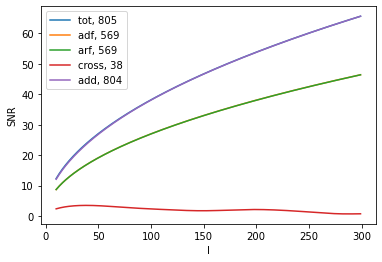

In [43]:
for p in datakeys:
    plt.plot(ells, snr_d[p], label=f'{p}, {np.sqrt(np.sum(snr_d[p]**2)):.0f}')


# plt.plot(ells, snr_adf, label=f'adf, {np.sqrt(np.sum(snr_adf**2)):.0f}')
# plt.plot(ells, snr_arf, label=f'arf, {np.sqrt(np.sum(snr_arf**2)):.0f}')
# plt.plot(ells, snr_tot , label=f'tot, {np.sqrt(np.sum(snr_tot**2)):.0f}')

plt.ylabel('SNR')
plt.xlabel('l')
    
plt.legend()

plt.savefig(opj(libdir, 'figs', 'snr.pdf'))


In [44]:
eps = 0.02

delta_par = {}
cls_dpar_p = {}
cls_dpar_m = {}

for par in params:
    print(par)
    fn_delta_par = f"delta_par_{par}_{eps}"
    fn_cls_dpar_p = f"cls_dpar_{par}_p_{eps}"
    fn_cls_dpar_m = f"cls_dpar_{par}_m_{eps}"
    
    if np.any([not cacher.is_cached(fn) for fn in [fn_delta_par, fn_cls_dpar_p, fn_cls_dpar_m]]):

        dpar_p = copy.deepcopy(fiducials)
        dpar_m = copy.deepcopy(fiducials)

        if dpar_p[par] == 0:
            dpar_p[par] = eps
            dpar_m[par] = - eps
            _delta_par = 2*eps
        else:
            dpar_p[par] *= 1 + eps
            dpar_m[par] *= 1 - eps
            _delta_par = 2*eps*fiducials[par]

        # Plus
        if par == 'logA':
            dpar_p['As'] = 1e-10 * np.exp(dpar_p['logA']) 
            dpar_m['As'] = 1e-10 * np.exp(dpar_m['logA']) 
        
        if 'H0' in params_cosmo:
            pars.set_cosmology(H0=dpar_p['H0'], ombh2=dpar_p['ombh2'], omch2=dpar_p['omch2'], mnu=dpar_p['mnu'], omk=dpar_p['omk'], tau=dpar_p['tau'])
        elif 'comomc_theta' in params_cosmo:
            pars.set_cosmology(cosmomc_theta=dpar_p['cosmomc_theta'], ombh2=dpar_p['ombh2'], omch2=dpar_p['omch2'], mnu=dpar_p['mnu'], omk=dpar_p['omk'], tau=dpar_p['tau'])
            
        pars.InitPower.set_params(As=dpar_p['As'], ns=dpar_p['ns'], r=0)
        

        bias_bin = np.array([dpar_p[f"b{i:02}"]*np.ones_like(zs) for i in range(nzbin)])

        pars.SourceWindows = get_source_windows(bias_bin)
            

        results_p = camb.get_results(pars)

        _cls_dpar_p = results_p.get_source_cls_dict(raw_cl=True)

        # Minus 

        if 'H0' in params_cosmo:
            pars.set_cosmology(H0=dpar_m['H0'], ombh2=dpar_m['ombh2'], omch2=dpar_m['omch2'], mnu=dpar_m['mnu'], omk=dpar_m['omk'], tau=dpar_m['tau'])
        elif 'cosmomc_theta' in params_cosmo:
            pars.set_cosmology(cosmomc_theta=dpar_m['cosmomc_theta'], ombh2=dpar_m['ombh2'], omch2=dpar_m['omch2'], mnu=dpar_m['mnu'], omk=dpar_m['omk'], tau=dpar_m['tau'])

        pars.InitPower.set_params(As=dpar_m['As'], ns=dpar_m['ns'], r=0)

         
        bias_bin = np.array([dpar_m[f"b{i:02}"]*np.ones_like(zs) for i in range(nzbin)])
        pars.SourceWindows = get_source_windows(bias_bin)

        
        results_m = camb.get_results(pars)

        _cls_dpar_m = results_m.get_source_cls_dict(raw_cl=True)
    
        cacher.cache(fn_delta_par, _delta_par)
        cacher.cache(fn_cls_dpar_p, _cls_dpar_p)
        cacher.cache(fn_cls_dpar_m, _cls_dpar_m)
    
    delta_par[par] = cacher.load(fn_delta_par)
    cls_dpar_p[par] = cacher.load(fn_cls_dpar_p)
    cls_dpar_m[par] = cacher.load(fn_cls_dpar_m)


logA
ns
cosmomc_theta
omch2
ombh2
b00
b01
b02
b03
b04
b05
b06
b07
b08
b09
b10
b11
b12
b13
b14
b15
b16
b17
b18
b19


In [45]:
# def get_fisher(params, cls_dpar_p, cls_dpar_m, invcov_l, cl_keys, ells):
#     print(cl_keys)
#     dcls_dpar = {}
#     for par in params:
#         dcls_dpar[par] = np.zeros([lmax, len(cl_keys)])
#         for il, ell in enumerate(ells):
# #             dcls_dpar[par][il] = np.zeros(len(cl_keys))
#             for ik, key in enumerate(cl_keys):
#                 dcls_dpar[par][ell][ik] = (cls_dpar_p[par][key][ell] - cls_dpar_m[par][key][ell])/(delta_par[par])
    
# #     fisher = np.zeros([npar, npar])
#     # invcov_w = like_euclid_wl.invcovmat_l
# #     print(cl_keys)
#     fisher_l = np.zeros([len(ells), npar, npar])
#     for il, ell in enumerate(ells):
#         for (i1, par1), (i2, par2) in itertools.combinations_with_replacement(enumerate(params), 2):
#             fisher_l[il, i1, i2] = np.dot(np.dot(dcls_dpar[par1][ell], invcov_l[il]), dcls_dpar[par2][ell])
# #         fisher_l[il] = fisher + fisher.T - np.diag(fisher.diagonal()) 
#     fisher = np.sum(fisher_l, axis=0)
#     fisher = fisher + fisher.T - np.diag(fisher.diagonal())    
#     return fisher, dcls_dpar, fisher_l

In [46]:
fiducials['mnu']*(1+eps) - fiducials['mnu']*(1-eps) 

0.0023999999999999994

In [47]:
delta_par

{'logA': 0.12215308439698339,
 'ns': 0.038547408,
 'cosmomc_theta': 0.00041628896867187097,
 'omch2': 0.004811776,
 'ombh2': 0.0008866284000000001,
 'b00': 0.056080000000000005,
 'b01': 0.05736842105263158,
 'b02': 0.05865684210526317,
 'b03': 0.05994526315789475,
 'b04': 0.06123368421052632,
 'b05': 0.0625221052631579,
 'b06': 0.06381052631578948,
 'b07': 0.06509894736842106,
 'b08': 0.06638736842105264,
 'b09': 0.06767578947368423,
 'b10': 0.0689642105263158,
 'b11': 0.07025263157894737,
 'b12': 0.07154105263157895,
 'b13': 0.07282947368421053,
 'b14': 0.07411789473684212,
 'b15': 0.0754063157894737,
 'b16': 0.07669473684210527,
 'b17': 0.07798315789473685,
 'b18': 0.07927157894736843,
 'b19': 0.08056}

In [48]:
def get_fisher(params, cls_dpar_p, cls_dpar_m, invcov_l, cl_keys, ells):
#     print(cl_keys)
    npar = len(params)
    dcls_dpar = {}
    for par in params:
        dcls_dpar[par] = np.zeros([len(ells), len(cl_keys)])
        for il, ell in enumerate(ells):
#             dcls_dpar[par][il] = np.zeros(len(cl_keys))
            for ik, key in enumerate(cl_keys):
                dcls_dpar[par][il][ik] = (cls_dpar_p[par][key][ell] - cls_dpar_m[par][key][ell])/(delta_par[par])
    
    fisher = np.zeros([npar, npar])
    # invcov_w = like_euclid_wl.invcovmat_l
#     print(cl_keys)
    fisher_l = np.zeros([len(ells), npar, npar])
    for il, l in enumerate_progress(ells):
        for (i1, par1), (i2, par2) in itertools.combinations_with_replacement(enumerate(params), 2):
            fisher_l[il, i1, i2] = np.dot(np.dot(dcls_dpar[par1][il], invcov_l[il]), dcls_dpar[par2][il])
#         fisher_l[il] = fisher + fisher.T - np.diag(fisher.diagonal()) 
    fisher = np.sum(fisher_l, axis=0)
    fisher = fisher + fisher.T - np.diag(fisher.diagonal())    
    return fisher, dcls_dpar, fisher_l

In [49]:
fish = {}
dcls_par = {}
fisher_l = {}

for p in datakeys:
    fish[p], dcls_par[p], fisher_l[p] = get_fisher(params, cls_dpar_p, cls_dpar_m, invcov[p], cl_keys_dict[p], ells)

# fish_tot, dcls_par_tot, fisher_l = get_fisher(params, cls_dpar_p, cls_dpar_m, invcov['tot'], cl_keys, ells)
# fish_adf, dcls_par_adf, _ = get_fisher(params, cls_dpar_p, cls_dpar_m, invcov['adf'], cl_adf_keys, ells)
# fish_arf, dcls_par_arf, _ = get_fisher(params, cls_dpar_p, cls_dpar_m, invcov['arf'], cl_arf_keys, ells)

 [00:00:03]  ---------> 99%
 [00:00:02]  ---------> 99%
 [00:00:01]  ---------> 99%
 [00:00:02]  ---------> 99%
 [00:00:02]  ---------> 99%


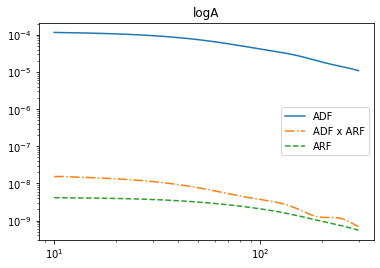

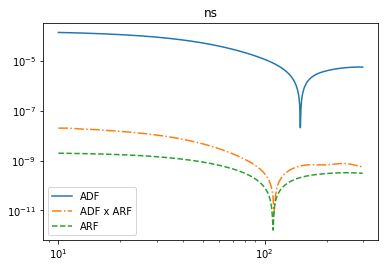

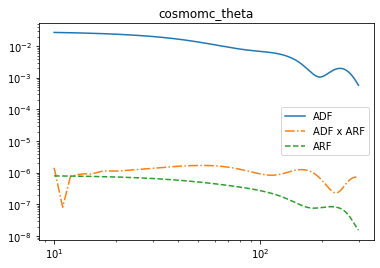

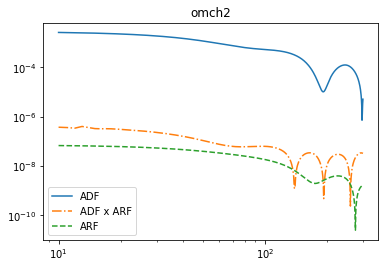

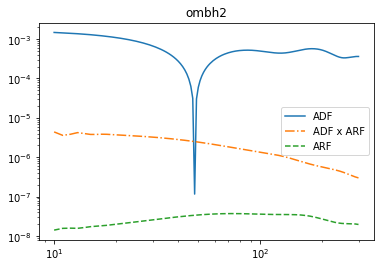

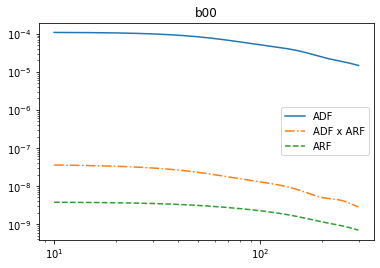

In [50]:

# for param in params_cosmo:
#     plt.figure()
#     plt.title(param)
#     for ik, key in enumerate(cl_keys):
#         i1, i2 = key.split('x')
#         if i1 == i2:
#             if int(i1[1:]) <= nzbin : 
#                 ls = '-'
#             else:
#                 ls='--'
#             plt.plot(ells, np.abs(dcls_par['tot'][param][:, ik]), label=key, ls=ls)

#     plt.loglog()
#     plt.legend()


for param in params_cosmo + ['b00']:
    plt.figure()
    plt.title(param)
    for ik, key in enumerate(cl_keys):
        i1, i2 = key.split('x')
        if i1[1:] == '1': 
            if i2[1:] == '1': 
                plt.plot(ells, np.abs(dcls_par['tot'][param][:, ik]), label='ADF', ls='-')
            elif i2[1:] == str(nzbin+1):
                plt.plot(ells, np.abs(dcls_par['tot'][param][:, ik]), label='ADF x ARF', ls='-.')
        elif i1[1:] == str(nzbin+1) and i2[1:] == str(nzbin+1):
                plt.plot(ells, np.abs(dcls_par['tot'][param][:, ik]), label='ARF', ls='--')

    plt.loglog()
    
    plt.legend()

In [53]:
for k, f in fish.items():
    print('')
    print(k)
    print(is_pos_def(f))
    print(np.linalg.eigvals(f))
    print(np.linalg.cond(f))



tot
True
[9.16163883e+09 2.29489735e+08 1.51412645e+06 6.37897240e+04
 3.35766879e+02 4.79660438e+04 4.52371980e+04 4.27528710e+04
 4.04929394e+04 3.84006934e+04 2.14895866e+04 2.23373486e+04
 2.30055152e+04 2.37921671e+04 3.64668069e+04 2.45905192e+04
 2.54772652e+04 2.65217408e+04 2.76260987e+04 2.88157990e+04
 3.01279786e+04 3.15344557e+04 3.46891899e+04 3.27448857e+04
 3.30397081e+04]
27285713.418643728

adf
True
[4.62743541e+09 7.93585366e+07 1.07206741e+02 4.67335637e+01
 2.15077848e+03 2.78761907e+04 2.64427725e+04 2.50759715e+04
 2.37685506e+04 2.25420521e+04 9.59735471e+03 2.13942488e+04
 2.03316403e+04 1.93481342e+04 1.84338527e+04 1.75926238e+04
 1.68026307e+04 1.20049775e+04 1.60709270e+04 1.25178244e+04
 1.53796211e+04 1.30340417e+04 1.47429809e+04 1.35734809e+04
 1.41402986e+04]
99017388.04819606

arf
True
[4.29905739e+09 5.45714259e+07 2.55912639e+01 4.43072705e+02
 4.14651063e+03 2.30777297e+04 2.15601185e+04 2.02803771e+04
 7.70301439e+03 1.91562312e+04 1.80570604e+04

In [54]:
for ip, par in enumerate(params):
#         if f[ip, ip] == 0:
#             print("{} : 0 ".format(par))
    print(f"{par} : {fiducials[par]:.3e}")
    for p, f in fish.items():

    #         print("{} : {} ".format(par, np.sqrt(1/fish[ip, ip]) / fiducials[par]))
    #         print("{} : {} ".format(par, np.sqrt(np.linalg.inv(fisher)[ip, ip]) / fiducials[par])) 
    #         print(np.linalg.inv(fisher)[ip, ip])

    #         print("  tot {} ".format(np.sqrt(np.abs(np.linalg.inv(fish_tot)[ip, ip])) / fiducials[par]))  
    #         print("  adf {} ".format(np.sqrt(np.abs(np.linalg.inv(fish_adf)[ip, ip])) / fiducials[par]))                  
    #         print("  arf {} ".format(np.sqrt(np.abs(np.linalg.inv(fish_arf)[ip, ip])) / fiducials[par]))  

            print(f"  {p} {np.sqrt(np.abs(np.linalg.inv(f)[ip, ip])):.3e} ")  

#             print("  adf {} ".format(np.sqrt(np.abs(np.linalg.inv(f)[ip, ip]))))                 

#             print("  arf {} ".format(np.sqrt(np.abs(np.linalg.inv(f)[ip, ip]))))  

logA : 3.054e+00
  tot 1.694e-02 
  adf 9.284e-02 
  arf 5.995e-02 
  cross 7.138e-02 
  add 3.687e-02 
ns : 9.637e-01
  tot 5.517e-03 
  adf 4.345e-02 
  arf 2.576e-02 
  cross 3.273e-02 
  add 1.868e-02 
cosmomc_theta : 1.041e-02
  tot 1.298e-04 
  adf 3.986e-03 
  arf 1.406e-03 
  cross 1.778e-04 
  add 1.291e-03 
omch2 : 1.203e-01
  tot 1.210e-03 
  adf 4.315e-02 
  arf 1.516e-02 
  cross 1.607e-03 
  add 1.397e-02 
ombh2 : 2.217e-02
  tot 1.276e-04 
  adf 4.336e-03 
  arf 1.991e-03 
  cross 1.432e-04 
  add 1.663e-03 
b00 : 1.402e+00
  tot 9.267e-03 
  adf 2.519e-02 
  arf 3.440e-02 
  cross 1.532e-02 
  add 1.314e-02 
b01 : 1.434e+00
  tot 1.031e-02 
  adf 2.582e-02 
  arf 3.545e-02 
  cross 2.443e-01 
  add 1.352e-02 
b02 : 1.466e+00
  tot 1.061e-02 
  adf 2.648e-02 
  arf 3.642e-02 
  cross 2.704e-01 
  add 1.391e-02 
b03 : 1.499e+00
  tot 1.092e-02 
  adf 2.713e-02 
  arf 3.756e-02 
  cross 2.760e-01 
  add 1.433e-02 
b04 : 1.531e+00
  tot 1.123e-02 
  adf 2.778e-02 
  arf 3.8

In [55]:

gauss = {}
for p in datakeys:
    gauss[p] = GaussianND(mean, np.linalg.inv(fish[p]), names=params, labels=labels, label=p)
# gauss_tot = GaussianND(mean, np.linalg.inv(fish['tot']), names=params, labels=labels, label='Tot')
# gauss_adf = GaussianND(mean, np.linalg.inv(fish['adf']), names=params, labels=labels, label='ADF')
# gauss_arf = GaussianND(mean, np.linalg.inv(fish['arf']), names=params, labels=labels, label='ARF')
# gauss_cross = GaussianND(mean, np.linalg.inv(fish['cross']), names=params, labels=labels, label='Cross')


In [56]:
st = '_'.join(params_cosmo)

In [57]:
 f'ellipses_maxdistbin{max_dist_bin}_{st}.pdf'

'ellipses_maxdistbin5_logA_ns_cosmomc_theta_omch2_ombh2.pdf'

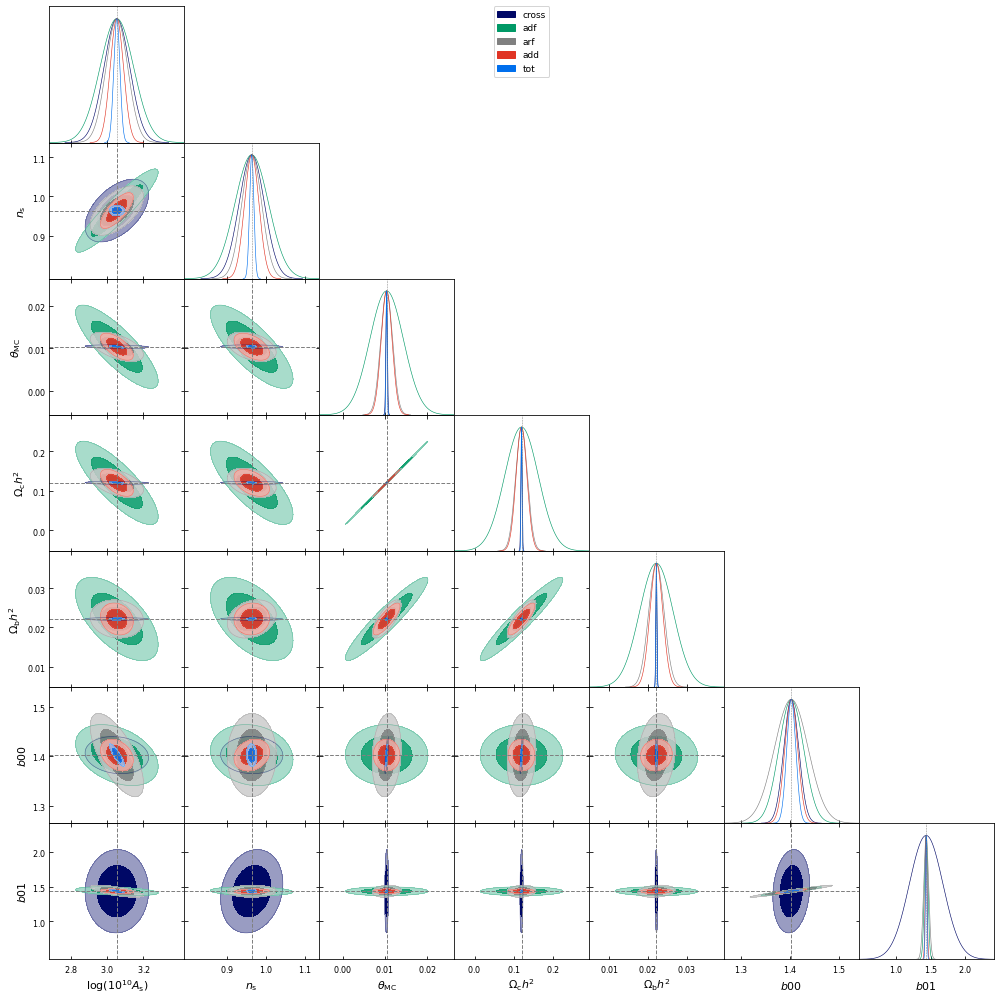

In [58]:
g = plots.get_subplot_plotter()

# g.triangle_plot([gauss_adf, gauss_arf, gauss_tot],  filled=True, 
#                 markers=fiducials, 
#                 marker_args={'lw':2.})

# g.triangle_plot([gauss_tot],  filled=True, 
#                 markers=fiducials, 
#                 marker_args={'lw':2.})

if marg_bias:
    g.triangle_plot([gauss['cross'], gauss['adf'], gauss['arf'], gauss['add'], gauss['tot']],  params_cosmo + ['b00', 'b01'], filled=True, 
#     g.triangle_plot([gauss['adf'], gauss['arf'], gauss['add'], gauss['tot']],  params_cosmo + ['b00', 'b01'], filled=True, 
#     g.triangle_plot([gauss['cross'], gauss['adf'], gauss['arf'], gauss['add'], gauss['tot']],  params_cosmo, filled=True, 
                markers=fiducials, 
                marker_args={'lw':1.})
    parstr = '_'.join(params_cosmo + ['b00', 'b01'])
#     g.export(opj(libdir, 'figs', f'ellipses_maxdistbin{max_dist_bin}_{parstr}.pdf'))    



In [59]:
param_limits = {
    'logA':[2.8, 3.3],
    'ns':[0.87, 1.07],
    'cosmomc_theta':[0.004, 0.02],
    'omch2':[0.05, 0.2],
    'ombh2':[0.01, 0.04],
    'mnu':[0.01, 0.1]
}

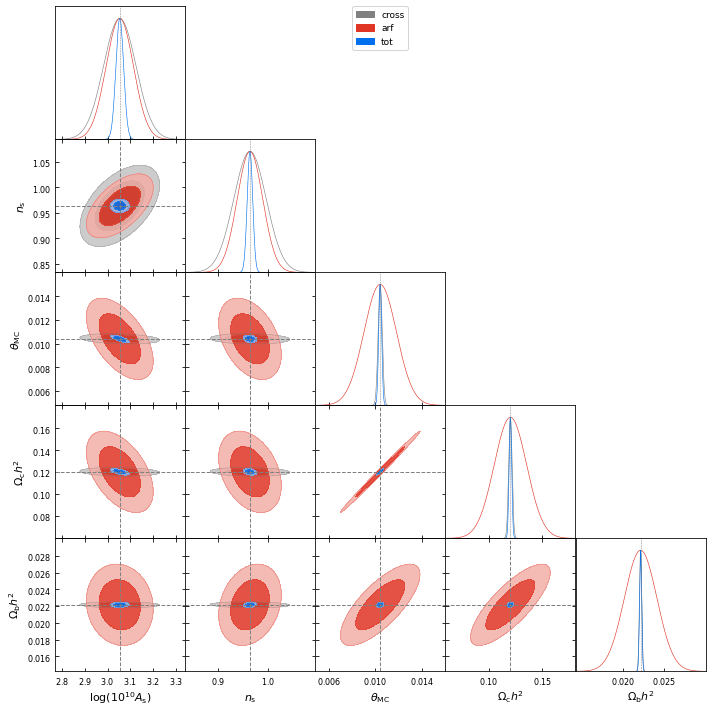

In [60]:
g = plots.get_subplot_plotter()

g.triangle_plot([gauss['cross'], gauss['arf'], gauss['tot']],  params_cosmo , filled=True, 
            markers=fiducials, 
#             param_limits=param_limits, 
            marker_args={'lw':1.})

parstr = '_'.join(params_cosmo)
g.export(opj(libdir, 'figs', f'ellipses_zoom_maxdistbin{max_dist_bin}_{parstr}.pdf'))  

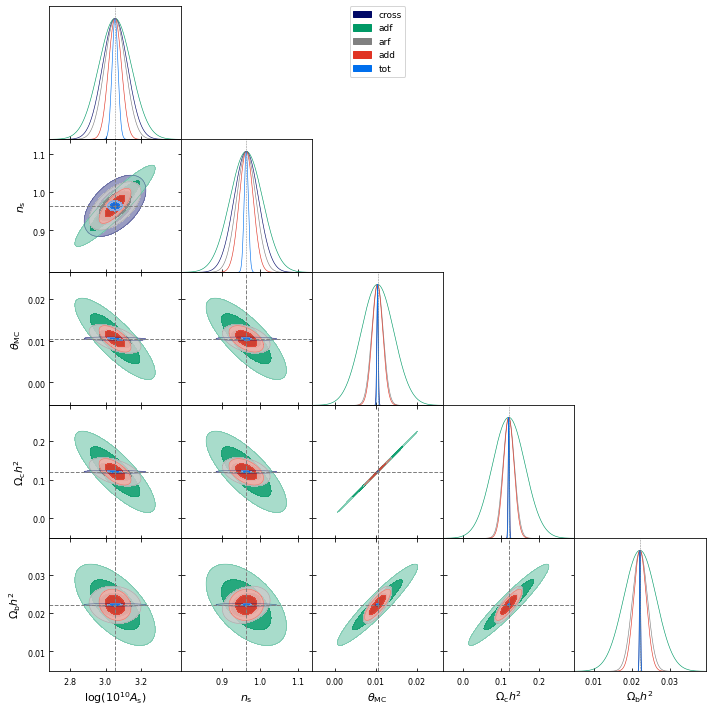

In [61]:
g = plots.get_subplot_plotter()

g.triangle_plot([gauss['cross'], gauss['adf'], gauss['arf'], gauss['add'], gauss['tot']],  params_cosmo , filled=True, 
            markers=fiducials, 
            marker_args={'lw':1.})

parstr = '_'.join(params_cosmo)
g.export(opj(libdir, 'figs', f'ellipses_maxdistbin{max_dist_bin}_{parstr}.pdf'))  

(5, 5)

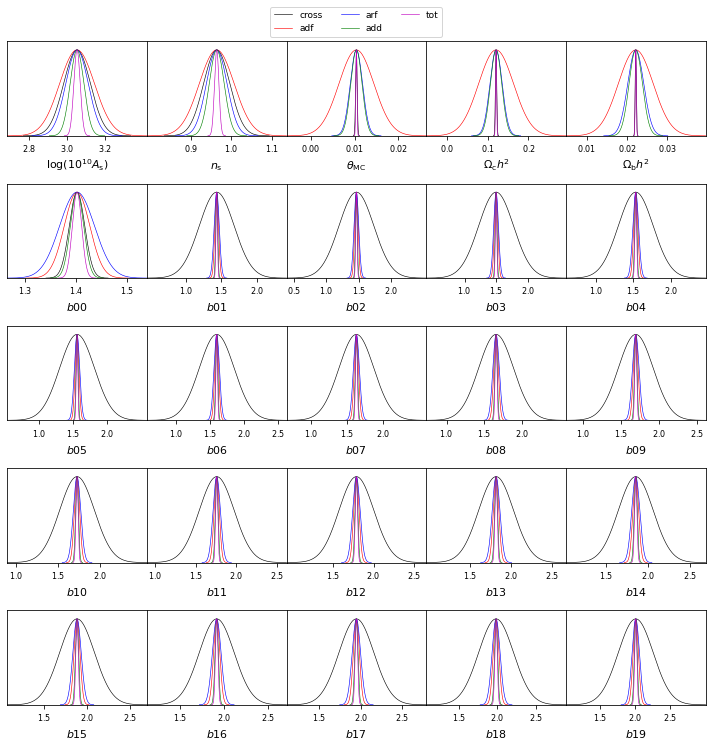

In [62]:
g.plots_1d([gauss['cross'], gauss['adf'], gauss['arf'], gauss['add'],  gauss['tot']], share_y=True, nx=len(params_cosmo), legend_ncol=3)

In [63]:
g = plots.get_single_plotter(width_inch=6)


if 'mnu'in params:
#     g.plots_1d([gauss['cross'], gauss['adf'], gauss['arf'], gauss['add'],  gauss['tot']], 'mnu', legend_ncol=3,colors='Set1')
    
    g.plots_1d([gauss['cross'], gauss['arf'], gauss['add'],  gauss['tot']], 'mnu', legend_ncol=3,colors='tab10')   
    
    

<Figure size 432x324 with 0 Axes>